In [1]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.utils.training_utils import multi_gpu_model
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
import matplotlib.image as mpimg
import pandas as pd
import os
%matplotlib inline

/scratchd/home/rishab/anaconda3/envs/myenv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))

# Load Data

In [3]:
testFiles = glob.glob('../Test/*.jpg')
print (len(testFiles))

16111


In [4]:
trainFileClasses = glob.glob('../Train/*')
#trainFileClasses

In [5]:
trainFiles = [] # list of files for one class [0]
for i in range(len(trainFileClasses)):
    trainFiles.append(glob.glob(trainFileClasses[i] + '/*.jpg'))


In [6]:
trainFilesFlat = [] # flattened version
trainLabels = [] #flattened version
for i in range(len(trainFiles)):
    trainFilesFlat += trainFiles[i]
    trainLabels += [trainFileClasses[i].split('/')[-1]] * len(trainFiles[i])
print (len(trainFilesFlat), len(trainLabels))
# Old number 38217. Removed None images now

38211 38211


In [7]:
trainData = pd.DataFrame({'filenames' : trainFilesFlat, 'labels' : trainLabels})
del trainFileClasses
del trainFiles
del trainFilesFlat
del trainLabels
trainData.head()

,filenames,labels
0,../Train/BabyBibs/BabyBibs_10.jpg,BabyBibs
1,../Train/BabyBibs/BabyBibs_100.jpg,BabyBibs
2,../Train/BabyBibs/BabyBibs_1000.jpg,BabyBibs
3,../Train/BabyBibs/BabyBibs_1001.jpg,BabyBibs
4,../Train/BabyBibs/BabyBibs_1002.jpg,BabyBibs


In [8]:
classes = trainData['labels'].unique()

In [9]:
# Shuffle the data
trainData = trainData.sample(frac=1).reset_index(drop=True)
trainData.tail()

,filenames,labels
38206,../Train/womendollshoes/womendollshoes_1348.jpg,womendollshoes
38207,../Train/womensleevelesstop/womensleevelesstop...,womensleevelesstop
38208,../Train/womenpeashoes/womenpeashoes_261.jpg,womenpeashoes
38209,../Train/womenlazyshoes/womenlazyshoes_2804.jpg,womenlazyshoes
38210,../Train/PackageFart/PackageFart_703.jpg,PackageFart


In [10]:
# Get dev data here
devData = []
classes

array(['BabyBibs', 'BabyHat', 'BabyPants', 'BabyShirt', 'PackageFart',
       'womanshirtsleeve', 'womencasualshoes', 'womenchiffontop',
       'womendollshoes', 'womenknittedtop', 'womenlazyshoes',
       'womenlongsleevetop', 'womenpeashoes', 'womenplussizedtop',
       'womenpointedflatshoes', 'womensleevelesstop', 'womenstripedtop',
       'wrapsnslings'], dtype=object)

### Show Sample images

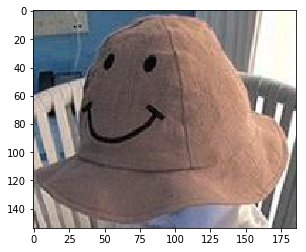

In [11]:
img = cv2.imread(trainData[trainData['labels'] == 'BabyHat']['filenames'].iloc[0])
plt.imshow(img)

(224, 224, 3)


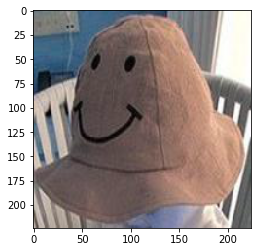

In [12]:
def getImage(filename):
    try:
        img = cv2.imread(filename)
        img = cv2.resize(img, (224, 224))
    except:
        print ("===ERROR===", filename)
    return img
img = getImage(trainData[trainData['labels'] == 'BabyHat']['filenames'].iloc[0])
print (img.shape)
plt.imshow(img)

In [26]:
def myGenerator(trainx, trainy, batch_size):
    while 1:
        imax = int(len(trainx) / batch_size)
        for i in range(imax):
#             batchtrx = []
#             batchtry = []
#             for j in range(batch_size):
#                 img = getImage(trainx[i*batch_size + j])
#                 batchtrx.append(img)
#                 batchtry.append(trainy[i*batch_size + j])
#             batchtrx = np.array(batchtrx)
#             batchtry = np.array(batchtry)
            batchtrx = trainx[i * batch_size : (i + 1) * batch_size]
            batchtry = trainy[i * batch_size : (i + 1) * batch_size]
            batchtrx = np.array(batchtrx)
            batchtry = np.array(batchtry)
            #print (batchtrx.shape, batchtry.shape)
            yield batchtrx, batchtry

In [15]:
# Some images are None
# img = cv2.imread('../Train/BabyPants/BabyPants_1.jpg')
# print (img)

In [17]:
%%time
# TAKES A LOT OF TIME TO RUN. Im loading in RAM as o/w generator was slow
trainfilenames = trainData['filenames']
trainx = [getImage(fname) for fname in trainfilenames]

CPU times: user 2min 38s, sys: 18.5 s, total: 2min 57s
Wall time: 6min


In [18]:
trainy = trainData['labels']
trainy = [np.where(classes == x)[0][0] for x in trainy]
trainy = to_categorical(trainy)

In [19]:
DEV_SPLIT = 0.8
devx = trainx[int(len(trainx)*DEV_SPLIT):]
devy = trainy[int(len(trainy)*DEV_SPLIT):]
trainx = trainx[:int(len(trainx)*DEV_SPLIT)]
trainy = trainy[:int(len(trainy)*DEV_SPLIT)]

# Model 1 - Resnet

In [20]:
def getModel():
    baseModel = applications.ResNet50(weights='imagenet', include_top = False, input_shape=(224, 224, 3))
    x = baseModel.output
    x = GlobalAveragePooling2D()(x) # flatten can be tried too. Essentially same thing in resnet
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    preds = Dense(len(classes), activation='softmax')(x)
    model = Model(inputs=baseModel.input, outputs=preds)
    #model.summary()
    for layer in baseModel.layers:
        layer.trainable = False
    return model

In [21]:
BATCH_SIZE = 64
NUM_EPOCHS = 10
GPUS = 5 # CHANGE ACC TO YOUR SYSTEM

if GPUS > 1:
    with tf.device("/cpu:0"):
        model = getModel()
    model = multi_gpu_model(model, gpus = GPUS)
else:
    model = getModel()

In [22]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_4 (

In [23]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])

In [24]:
callbacks = [EarlyStopping(patience = 3, verbose = 1)]
#callbacks = [EarlyStopping(patience = 3, verbose = 1), TensorBoard()]  # USE THIS IN FUTURE

In [27]:
model.fit_generator(myGenerator(trainx, trainy, batch_size = BATCH_SIZE * GPUS),
                    steps_per_epoch= len(trainx) // (BATCH_SIZE * GPUS), 
                    epochs=NUM_EPOCHS, 
                    verbose=1, 
                    callbacks=callbacks, 
                    validation_data=myGenerator(devx, devy, batch_size = BATCH_SIZE * GPUS), 
                    validation_steps= len(devx) // (BATCH_SIZE * GPUS))


Epoch 1/10
95/95 [==============================] - 141s 1s/step - loss: 1.2650 - acc: 0.5863 - val_loss: 1.1222 - val_acc: 0.6132
Epoch 2/10
95/95 [==============================] - 120s 1s/step - loss: 0.8081 - acc: 0.7189 - val_loss: 1.0986 - val_acc: 0.6329
Epoch 3/10
95/95 [==============================] - 53s 560ms/step - loss: 0.6889 - acc: 0.7565 - val_loss: 1.1002 - val_acc: 0.6390
Epoch 4/10
95/95 [==============================] - 53s 556ms/step - loss: 0.6123 - acc: 0.7830 - val_loss: 1.0610 - val_acc: 0.6474
Epoch 5/10
95/95 [==============================] - 54s 573ms/step - loss: 0.5551 - acc: 0.8024 - val_loss: 1.0349 - val_acc: 0.6647
Epoch 6/10
95/95 [==============================] - 54s 566ms/step - loss: 0.5063 - acc: 0.8214 - val_loss: 1.0833 - val_acc: 0.6486
Epoch 7/10
95/95 [==============================] - 53s 562ms/step - loss: 0.4624 - acc: 0.8354 - val_loss: 1.1174 - val_acc: 0.6520
Epoch 8/10
95/95 [==============================] - 53s 562ms/step - loss

In [38]:
from keras.models import load_model

# Workaround to save multi gpu models not working. Will include custom callback later
# with tf.device("/cpu:0"):
#     singleGPUModel = getModel()
# singleGPUModel.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])
# singleGPUModel.set_weights(model.get_weights())
# singleGPUModel.save('models/resnet50_10epochs_01_model.h5')
#model.save('resnet50_10epochs_01_model.h5')

# json_string = model.to_json()
# f = open('models/resnet50_10epochs_01_architecture.json', 'w')
# f.write(json_string)
# f.close()

model.save_weights('models/resnet50_10epochs_01_weights.h5')

# Try Data Augmentation

# Test and generate submission

In [28]:
%%time
# TAKES A LOT OF TIME TO RUN. Im loading in RAM as o/w generator was slow
testx = [getImage(fname) for fname in testFiles]

CPU times: user 59.2 s, sys: 5.62 s, total: 1min 4s
Wall time: 1min 26s


In [32]:
testx = np.array(testx)

In [33]:
preds = model.predict(testx, verbose = 1, batch_size = (BATCH_SIZE * GPUS))

16111/16111 [==============================] - 103s 6ms/step


In [41]:
preds = [np.argmax(p) for p in preds]

In [55]:
testIds = [int(x.split('_')[-1].split('.')[0]) for x in testFiles]

In [56]:
submission = pd.DataFrame({'id' : testIds, 'category' : preds})

In [57]:
submission.head()

,category,id
0,5,1
1,0,10
2,9,100
3,0,1000
4,15,10000


In [58]:
columnsTitles=["id","category"]
submission = submission.reindex(columns=columnsTitles)
submission.head()

,id,category
0,1,5
1,10,0
2,100,9
3,1000,0
4,10000,15


In [61]:
submission = submission.sort_values(by = ['id'])
submission.head()

,id,category
0,1,5
7223,2,0
8334,3,11
9445,4,1
10556,5,13


In [66]:
submission.to_csv('submissions/resnet50_10epochs_01.csv', index = False)

# Mapping

In [63]:
mappingCategory = {}
for i in range(len(classes)):
    mappingCategory[classes[i]] = i
mappingCategory

{'BabyBibs': 0,
 'BabyHat': 1,
 'BabyPants': 2,
 'BabyShirt': 3,
 'PackageFart': 4,
 'womanshirtsleeve': 5,
 'womencasualshoes': 6,
 'womenchiffontop': 7,
 'womendollshoes': 8,
 'womenknittedtop': 9,
 'womenlazyshoes': 10,
 'womenlongsleevetop': 11,
 'womenpeashoes': 12,
 'womenplussizedtop': 13,
 'womenpointedflatshoes': 14,
 'womensleevelesstop': 15,
 'womenstripedtop': 16,
 'wrapsnslings': 17}

In [65]:
import json
with open('mappingCategory.json', 'w') as f:
    json.dump(mappingCategory, f)